# **1 | Importation des librairies :** 
Pour les modèles ML: Tensorflow, keras

Pour le pré-traitement des données: numpy, PIL, sklearn

Pour la visualisation des données: matplotlib, seaborn

Autres importations : os, random

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
from tqdm import tqdm
import os
import random



# **2 | Connexion à google drive :** 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

url_Training = "/content/drive/MyDrive/archive/Training"
url_Testing = "/content/drive/MyDrive/archive/Testing"
# data = pd.read_csv(url)

Mounted at /content/drive




# **3 | Importation des données :** 


In [ ]:
train_dir = url_Training
test_dir = url_Testing

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

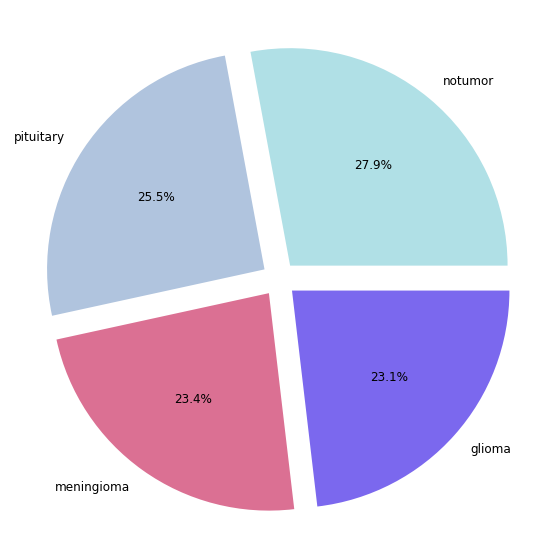

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


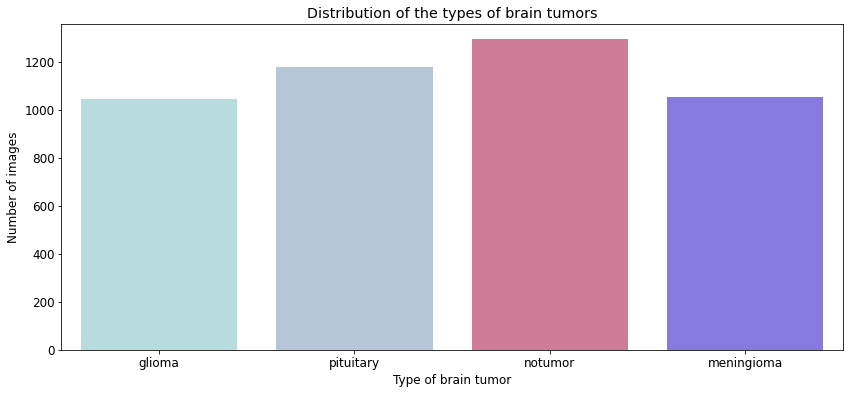

In [ ]:
plt.figure(figsize=(10,10))
colors = ['#B0E0E6','#B0C4DE','#DB7093','#7B68EE']
plt.pie([len(os.listdir(train_dir+"//" +label)) 
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08) 
           ,autopct='%1.1f%%')
plt.show()




plt.figure(figsize=(14,6))
sns.countplot(train_labels, palette=colors)
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');


In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
len(train_paths)

4376

In [ ]:
len(test_paths)

1311

In [ ]:
train_paths[0]

'/content/drive/MyDrive/archive/Training//pituitary//Tr-pi_0836.jpg'

In [ ]:
np.array(load_img(train_paths[555])).shape

(512, 512, 3)



# **4 | Data augmentation :** 
Random Brightness: 80% - 120%

Random Contrast: 80% - 120%


Random sharpness: 80% - 120%


In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image


# **5 | Visualisation des données :** 

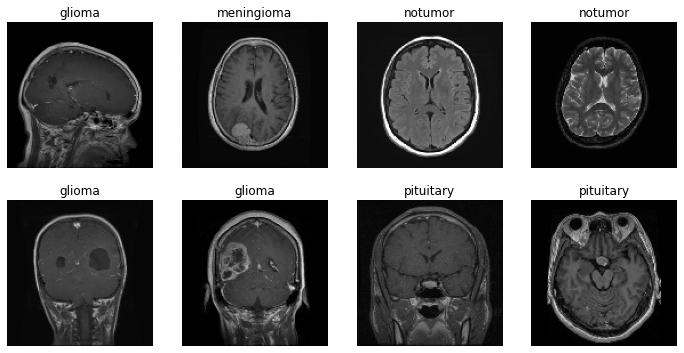

In [ ]:
IMAGE_SIZE = 128
def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()


# **6 | Data Generator :**
Étant donné une liste de chemins vers des images, et les labels,
cette fonction augmente les images, les normalise, encode les labels, puis renvoie le lot sur lequel le modèle peut s'entraîner. 

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
import tensorflow
tensorflow.keras.backend.clear_session()


# **7 | Modèle CNN :**



In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)      

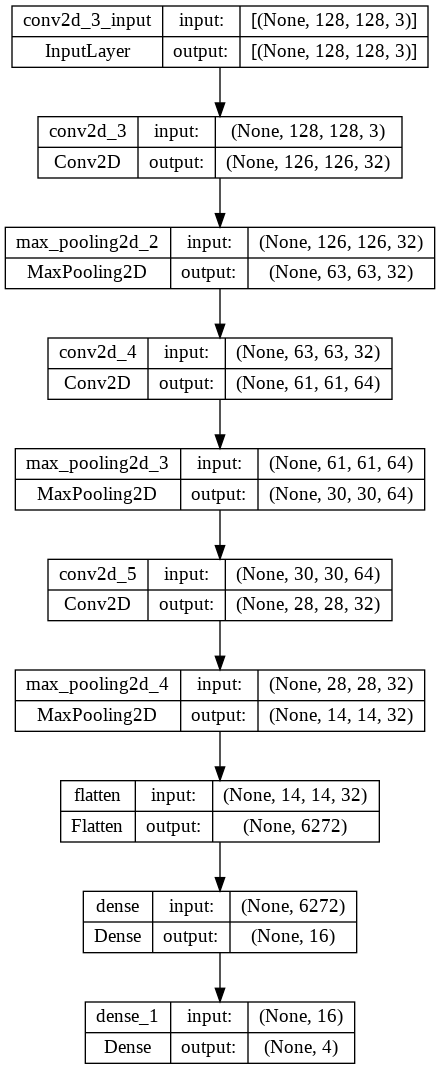

In [ ]:
tensorflow.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# **8 | Diviser le "training-set" en "Training" et "Validation" :**



In [ ]:
train_paths, X_val, train_labels, y_val = train_test_split(train_paths, train_labels, test_size=0.20, random_state= 8)


# **9 | Entraîner le modèle CNN :**



In [ ]:
history = model.fit(datagen(train_paths, train_labels, batch_size=32, epochs=30), steps_per_epoch=len(train_paths)//32, 
                    epochs=30 , validation_data = ( open_images(X_val), encode_label( y_val) ) )

Epoch 1/30
142/142 [==============================] - 2209s 16s/step - loss: 0.9328 - accuracy: 0.5874 - val_loss: 0.6585 - val_accuracy: 0.7218
Epoch 2/30
142/142 [==============================] - 36s 174ms/step - loss: 0.5530 - accuracy: 0.7838 - val_loss: 0.4628 - val_accuracy: 0.8198
Epoch 3/30
142/142 [==============================] - 25s 174ms/step - loss: 0.4450 - accuracy: 0.8396 - val_loss: 0.4108 - val_accuracy: 0.8364
Epoch 4/30
142/142 [==============================] - 25s 176ms/step - loss: 0.3651 - accuracy: 0.8599 - val_loss: 0.3829 - val_accuracy: 0.8504
Epoch 5/30
142/142 [==============================] - 25s 176ms/step - loss: 0.2955 - accuracy: 0.8889 - val_loss: 0.3479 - val_accuracy: 0.8740
Epoch 6/30
142/142 [==============================] - 26s 182ms/step - loss: 0.2429 - accuracy: 0.9083 - val_loss: 0.3272 - val_accuracy: 0.8845
Epoch 7/30
142/142 [==============================] - 24s 173ms/step - loss: 0.1862 - accuracy: 0.9308 - val_loss: 0.3162 - val_ac


# **10 | Evaluer le modèle :**





In [ ]:
train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

41/41 [==============================] - 1s 12ms/step - loss: 0.4356 - accuracy: 0.9260
Train accuracy: 0.9964988827705383
Test accuracy: 0.9260106682777405



# **11 | Visualisation des graphes :**
  - Training and Validation Accuracy
  -Training and Validation Loss



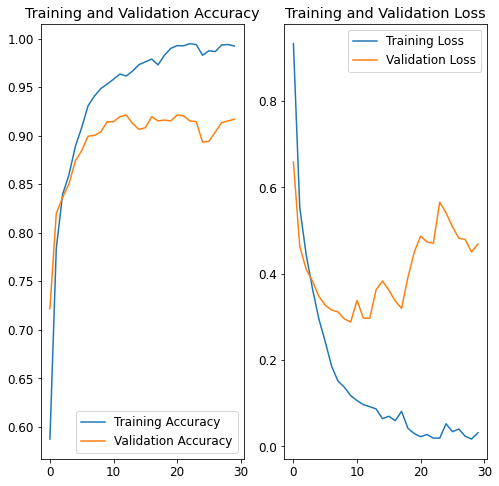

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **12 | Évaluer le modèle avec des échantillons de test :**

Matrice de confusion

In [ ]:
predictions = model.predict(open_images(test_paths))
predictions = np.argmax(predictions, axis=1)
print(classification_report(encode_label(test_labels), predictions, target_names=unique_labels))

41/41 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

     notumor       0.97      0.98      0.97       405
   pituitary       0.94      0.98      0.96       300
  meningioma       0.88      0.86      0.87       306
      glioma       0.93      0.90      0.92       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



In [ ]:
def visualize_conv_layer(layer_name):
  
  layer_output=model.get_layer(layer_name).output  #get the Output of the Layer
  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we are concerned about
  intermediate_prediction=intermediate_model.predict(open_images(train_paths)[4].reshape(1,128,128,3)) #predicting in the Intermediate Node
  
  row_size=3
  col_size=3
  
  img_index=0
  print(np.shape(intermediate_prediction))
#---------------We will subplot the Output of the layer which will be the layer_name----------------------------------#
  
  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8)) 
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')
      img_index=img_index+1 #Increment the Index number of img_index variable
        
print("Function to Visualize the Output has been Created")

Function to Visualize the Output has been Created


In [ ]:
import tensorflow as tf

1/1 [==============================] - 0s 41ms/step
(1, 126, 126, 32)


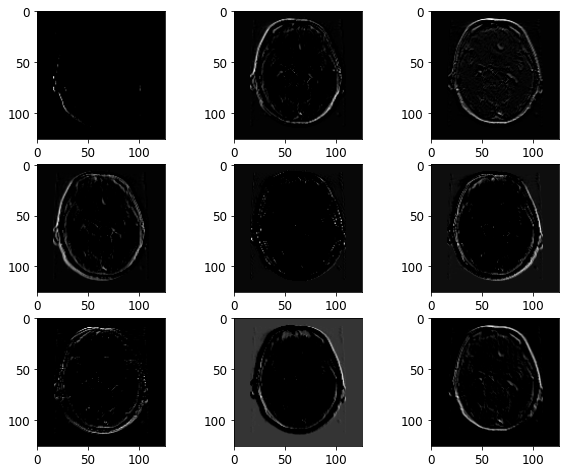

In [ ]:
visualize_conv_layer("conv2d_3")

1/1 [==============================] - 0s 54ms/step
(1, 28, 28, 32)


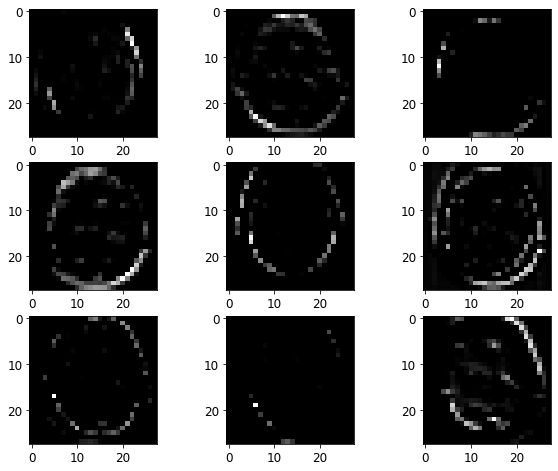

In [ ]:
visualize_conv_layer("conv2d_5")

1/1 [==============================] - 0s 36ms/step
(1, 63, 63, 32)


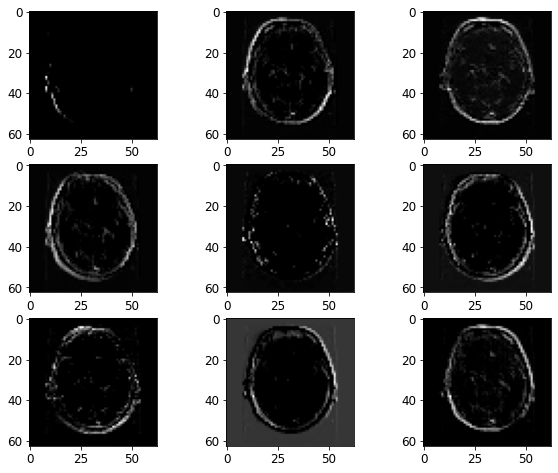

In [ ]:
visualize_conv_layer("max_pooling2d_2")

In [ ]:
layer_output=model.get_layer("flatten").output  #get the Output of the Layer
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we are concerned about
intermediate_prediction=intermediate_model.predict(open_images(train_paths)[4].reshape(1,128,128,3))
print(intermediate_prediction)

1/1 [==============================] - 0s 66ms/step
[[0. 0. 0. ... 0. 0. 0.]]


In [ ]:
len(intermediate_prediction[0])

6272

In [ ]:
intermediate_prediction[0].max()

11.096543

In [ ]:
layer_output=model.get_layer("dense").output  #get the Output of the Layer
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we are concerned about
intermediate_prediction=intermediate_model.predict(open_images(train_paths)[4].reshape(1,128,128,3))
print(intermediate_prediction)

1/1 [==============================] - 0s 56ms/step
[[ 0.        27.347816   0.        20.09704    0.         0.
  12.3502445 29.91264    0.         0.         0.        14.969976
   0.         0.         0.         0.       ]]


In [ ]:
layer_output=model.get_layer("dense_1").output  #get the Output of the Layer
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we are concerned about
intermediate_prediction=intermediate_model.predict(open_images(train_paths)[4].reshape(1,128,128,3))
print(intermediate_prediction)

1/1 [==============================] - 0s 124ms/step
[[4.8802362e-15 1.4454329e-10 3.6977435e-10 1.0000000e+00]]


In [ ]:
len(model.layers[0].get_weights()[0])

3

In [ ]:
print("These are the weights of a Layer")
print("----------------------------------------------------------------------")
model.layers[0].get_weights()

These are the weights of a Layer
----------------------------------------------------------------------


[array([[[[-7.54645169e-02,  1.09039262e-01,  3.40279080e-02,
           -6.23958360e-04,  1.92608878e-01,  1.01913204e-02,
           -6.83989152e-02,  1.11741535e-01, -3.34459208e-02,
            2.95059364e-02, -9.42912847e-02, -1.47375651e-02,
            1.60955876e-01,  1.47330850e-01, -1.02106616e-01,
           -3.72152515e-02, -2.11442430e-02, -1.51103854e-01,
           -3.46056372e-02, -9.29956213e-02, -9.91063491e-02,
           -7.74269477e-02,  9.90047827e-02,  1.25116661e-01,
            9.62799564e-02, -3.07673530e-04,  8.21534395e-02,
            5.04533108e-03, -1.52972788e-01, -1.41052842e-01,
           -1.34623483e-01,  1.49173394e-01],
          [-1.23837553e-01, -1.48012266e-02, -1.32388934e-01,
            8.83484408e-02,  2.69390587e-02,  1.83039203e-01,
           -7.21890107e-02,  6.50256127e-02, -8.41988549e-02,
            8.08948874e-02,  1.99979469e-02, -7.21959695e-02,
           -4.29831818e-03, -2.59340405e-02,  9.84628424e-02,
            1.25012979e-

# **13 | Modèle CNN amélioré :**
L'ajout de : 
  - Data augmentation
  -Dropout

In [ ]:
def build_model1():
    model1 = Sequential()

    model1.add(RandomFlip("horizontal",input_shape=(128, 128, 3)))
    model1.add(RandomRotation(0.1))
    model1.add(RandomZoom(0.1))
    
    model1.add(Conv2D(32, (3, 3), activation='relu'))

    model1.add(MaxPooling2D((2, 2)))
    model1.add(Conv2D(64, (3, 3), activation='relu'))
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Conv2D(32, (3, 3), activation='relu'))
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.2))
    model1.add(Flatten())
    model1.add(Dense(16, activation='relu'))
    model1.add(Dense(4, activation='softmax'))
    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model1

model1 = build_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        1

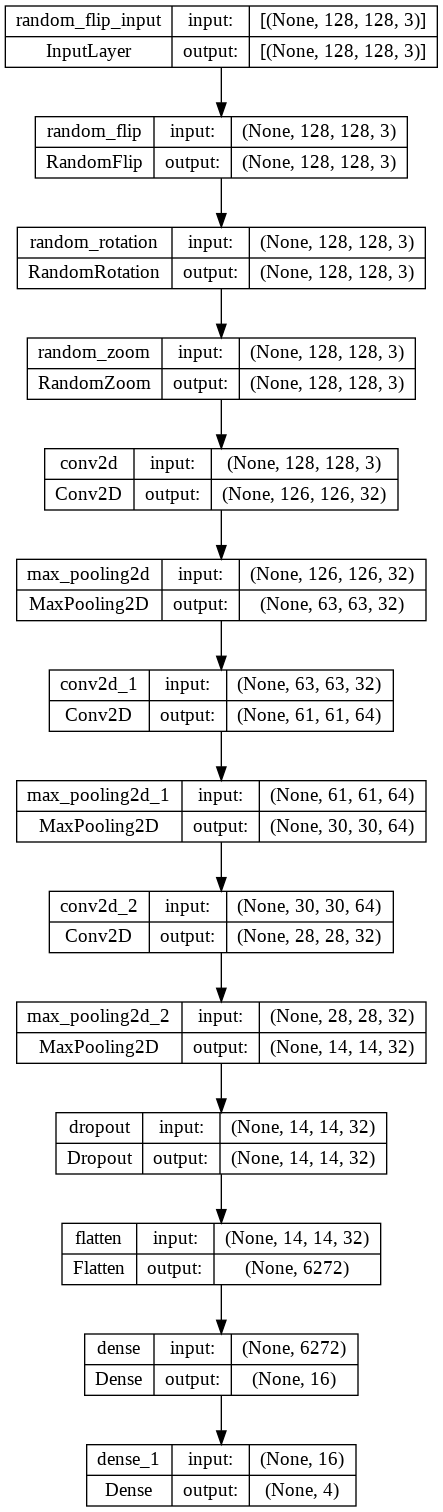

In [ ]:
tensorflow.keras.utils.plot_model(model1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

# **14 | Entraîner le nouveau modèle :**

In [ ]:
history1 = model1.fit(datagen(train_paths, train_labels, batch_size=32, epochs=30), steps_per_epoch=len(train_paths)//32, 
                    epochs=30 , validation_data = ( open_images(X_val), encode_label( y_val) ) )

Epoch 1/30
142/142 [==============================] - 29s 198ms/step - loss: 0.9240 - accuracy: 0.6089 - val_loss: 1.2449 - val_accuracy: 0.5214
Epoch 2/30
142/142 [==============================] - 27s 188ms/step - loss: 0.7184 - accuracy: 0.7085 - val_loss: 0.9166 - val_accuracy: 0.6675
Epoch 3/30
142/142 [==============================] - 27s 188ms/step - loss: 0.6365 - accuracy: 0.7475 - val_loss: 0.5150 - val_accuracy: 0.7944
Epoch 4/30
142/142 [==============================] - 26s 187ms/step - loss: 0.5835 - accuracy: 0.7726 - val_loss: 0.5582 - val_accuracy: 0.7944
Epoch 5/30
142/142 [==============================] - 28s 196ms/step - loss: 0.5568 - accuracy: 0.7726 - val_loss: 0.6372 - val_accuracy: 0.7734
Epoch 6/30
142/142 [==============================] - 26s 186ms/step - loss: 0.5099 - accuracy: 0.7970 - val_loss: 0.4772 - val_accuracy: 0.8136
Epoch 7/30
142/142 [==============================] - 28s 195ms/step - loss: 0.4864 - accuracy: 0.8087 - val_loss: 0.6375 - val_ac

# **15 | Evaluer le nouveau modèle :**

In [ ]:
train_loss, train_acc = model1.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model1.evaluate(open_images(test_paths), encode_label(test_labels))

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

41/41 [==============================] - 0s 10ms/step - loss: 0.3138 - accuracy: 0.8764
Train accuracy: 0.9343544840812683
Test accuracy: 0.8764302134513855


# **16 | Visualisation des graphes :**
  - Training and Validation Accuracy
  -Training and Validation Loss

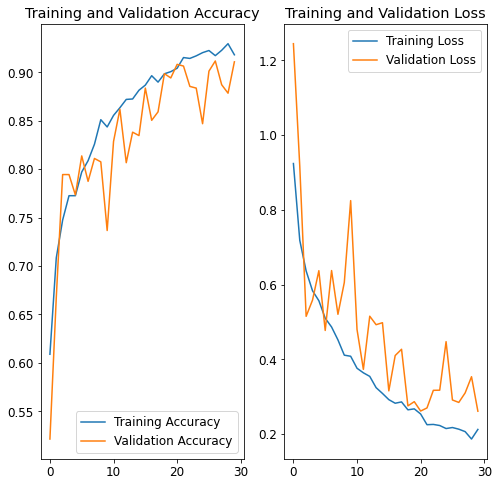

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **17 | Évaluer le nouveau modèle avec des échantillons de test :**

Matrice de confusion

In [ ]:
predictions = model1.predict(open_images(test_paths))
predictions = np.argmax(predictions, axis=1)
print(classification_report(encode_label(test_labels), predictions, target_names=unique_labels))

41/41 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

     notumor       0.92      0.99      0.95       405
   pituitary       0.82      1.00      0.90       300
  meningioma       0.82      0.75      0.78       306
      glioma       0.99      0.77      0.86       300

    accuracy                           0.88      1311
   macro avg       0.89      0.88      0.88      1311
weighted avg       0.89      0.88      0.88      1311



# **18 | Modèle VGG16 :**

L'utilisation du "Transfer learning":

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

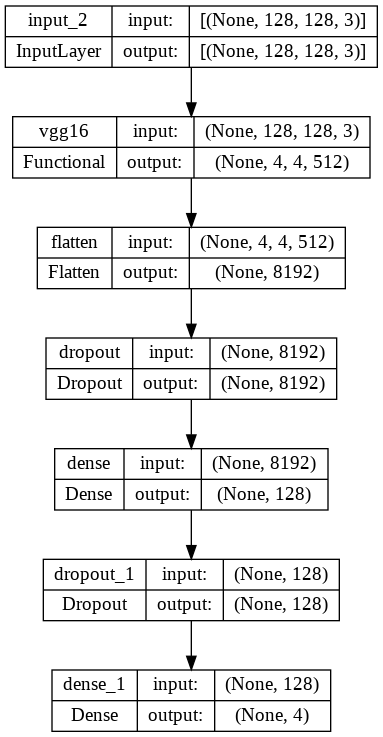

In [ ]:
tensorflow.keras.utils.plot_model(model, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

# **19 | Entraîner le modèle VGG :**

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 25
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps,  validation_data = ( open_images(X_val), encode_label( y_val) ))

Epoch 1/25
198/198 [==============================] - 30s 141ms/step - loss: 0.5601 - sparse_categorical_accuracy: 0.7755 - val_loss: 0.3139 - val_sparse_categorical_accuracy: 0.8841
Epoch 2/25
198/198 [==============================] - 26s 126ms/step - loss: 0.2940 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.2913 - val_sparse_categorical_accuracy: 0.8952
Epoch 3/25
198/198 [==============================] - 26s 130ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9255 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.8891
Epoch 4/25
198/198 [==============================] - 24s 123ms/step - loss: 0.1568 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.1652 - val_sparse_categorical_accuracy: 0.9435
Epoch 5/25
198/198 [==============================] - 32s 163ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.1745 - val_sparse_categorical_accuracy: 0.9335
Epoch 6/25
198/198 [==============================] - 25s 127ms/step - loss: 0.1064 -

# **20 | Visualisation des graphes :**
  - Training and Validation Accuracy
  -Training and Validation Loss

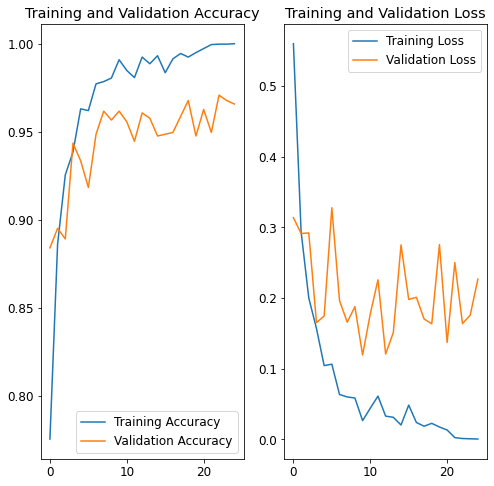

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **21 | Evaluer le modèle VGG :**

In [ ]:
train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

41/41 [==============================] - 2s 54ms/step - loss: 0.2613 - sparse_categorical_accuracy: 0.9687
Train accuracy: 0.9997479319572449
Test accuracy: 0.9687261581420898


# **Random Forest**
# **22 | Importation des données :**

In [ ]:
import tensorflow as tf
X_train = []
y_train = []

for i in train_paths:  
    image=tf.keras.preprocessing.image.load_img(i, 
    target_size= (128,128))
    image=np.array(image)
    X_train.append(image)
    
for i in train_labels:  
    y_train.append(i)
    
X_test = []
y_test = []

for i in test_paths:  
    image=tf.keras.preprocessing.image.load_img(i,
    target_size= (128,128))
    image=np.array(image)
    X_test.append(image)
    
for i in test_labels:  
    y_test.append(i)
    

In [ ]:
np.array(X_train).shape

(5713, 128, 128, 3)

In [ ]:
np.array(X_test).shape

(1311, 128, 128, 3)

In [ ]:
import pandas as pd

In [ ]:
X_train = pd.DataFrame(np.array(X_train).reshape(5713, 16384*3))
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(np.array(X_test).reshape(1311, 16384*3))
y_test = pd.DataFrame(y_test)

In [ ]:
X_train[0].max()

255

# **23 | Exemple de données :**

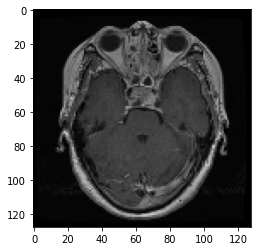

In [ ]:
plt.imshow(np.array(X_train.iloc[0]).reshape(128, 128 , 3))

# **24 | Normalisation :**

In [ ]:

X_train = X_train/255
X_test = X_test/255

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# **25 | Modèle Random Forest :**

In [ ]:
model=RandomForestClassifier()

# **26 | Entraîner le modèle :**

In [ ]:
model.fit(X_train,y_train)

<ipython-input-23-b7a8c64777c1>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RandomForestClassifier()

# **27 | Évaluer le modèle avec des échantillons de test :**

In [ ]:
y_pred=model.predict(X_test)
y_pred

array(['meningioma', 'notumor', 'glioma', ..., 'notumor', 'meningioma',
       'notumor'], dtype=object)

Matrice de confusion

In [ ]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

      glioma       0.84      0.97      0.90       262
  meningioma       0.93      0.86      0.89       331
     notumor       1.00      0.98      0.99       414
   pituitary       0.97      0.96      0.97       304

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311

